# Image modifications preview

## Imports

In [1]:
import numpy as np
import cv2 as cv
import pathlib
import random
from matplotlib import pyplot as plt
import typing as t
import functools

## Config

In [2]:
%matplotlib --list

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'gtk4', 'wx', 'qt4', 'qt5', 'qt6', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


In [3]:
%matplotlib inline

In [4]:
IMAGES_PATH = pathlib.Path.home().joinpath("/media/cicheck/Extreme Pro/datasets/originals/celeb_df/reals")
NO_IMAGES = len(list(IMAGES_PATH.iterdir()))

## Utils

In [5]:
def read_random_image() -> np.ndarray:
    """Read random image form set dictionary.
    
    Returns:
        Random image read.

    """
    all_images = list(IMAGES_PATH.iterdir())
    no_images = len(all_images)
    img_index = random.randint(0, no_images - 1)
    return cv.imread(str(all_images[img_index]))

def show_single_image(
    image: np.ndarray,
    figsize: t.Tuple[int, int] = (6.4, 4.8),
    dpi: int = 100,
) -> None:
    """Show single image.
    
    Args:
        image: OpenCV image.
        figsize: Size of displayed figure in inches.
        dpi: DPI of displayed figure.

    """
    fig, plot = plt.subplots()
    fig.set_size_inches(figsize)
    fig.set_dpi(dpi)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()

def show_single_image_modification(
    image: np.ndarray,
    mod_func: t.Callable,
    *args,
    figsize: t.Tuple[int, int] = (12.8, 9.8),
    dpi: int = 100,
    **kwargs,
) -> None:
    """Show effects of modification function on single image.
    
    Displayes orginal & modified images, side by side for comparission.

    Args:
        image: Original image.
        mod_func: Function used to modify image.
        *args: Arguments - to be passed to modification function.
        figsize: Size of displayed figure.
        dpi: DPI of displayed figure.
        **kwargs: Keyword arguments - to be passed to modification function.

    """
    mod_image = mod_func(image, *args, **kwargs)
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(figsize)
    fig.set_dpi(dpi)
    axes[0].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    axes[1].imshow(cv.cvtColor(mod_image, cv.COLOR_BGR2RGB))
    plt.show()

## Sample image

In [6]:
image = read_random_image()

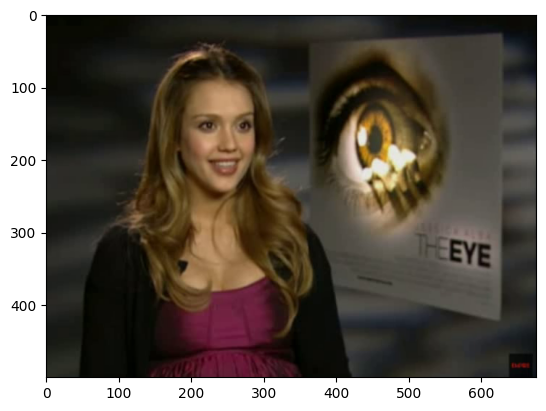

In [7]:
show_single_image(image)

## Gamma Correction

In [9]:
def gamma_correction(image: np.ndarray, gamma: float = 1.0) -> np.ndarray:
    """Perform gamma correction on provided image.
    
    Args:
        image: OpenCV image.
    
    Returns:
        Image after gamma correction.
    
    """
    rgb_max_value = 255
    look_up_table = np.array(
        [
            int(((i / rgb_max_value) ** (1.0 / gamma)) * rgb_max_value)
            for i in np.arange(0, 256)
        ]
    ).astype("uint8")
    # apply gamma correction using lookup table
    return cv.LUT(image, look_up_table)

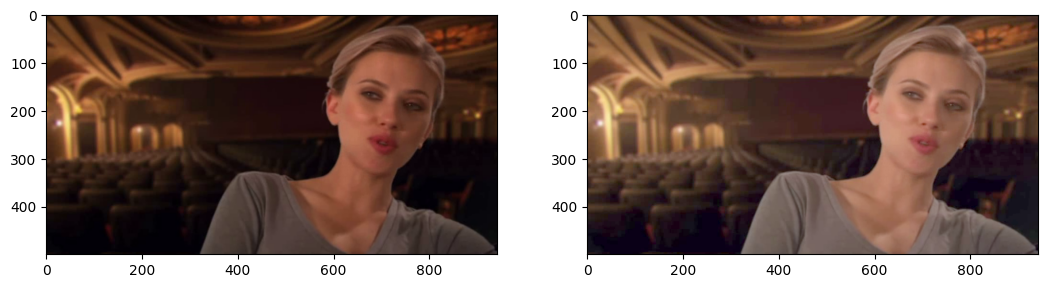

In [31]:
image = read_random_image()
show_single_image_modification(image, gamma_correction, gamma=1.5)

## Histogram Equalization

In [9]:
def histogram_equalization(image: np.ndarray) -> np.ndarray:
    """Perform Histogram Equalization on image.
    
    Equalization is done in YCbCr color space,
    after equalization image is converted back to BGR.
    
    Args:
        image: OpenCV image.
    
    Returns:
        Image after equalization.
    
    """
    # Convert from BGR color space to YCrCb
    ycrcb_image  = cv.cvtColor(image, cv.COLOR_BGR2YCrCb)
    # Eqalize y channel
    ycrcb_image[:, :, 0] = cv.equalizeHist(ycrcb_image[:, :, 0])
    # Convert back to BGR
    return cv.cvtColor(ycrcb_image, cv.COLOR_YCrCb2BGR)

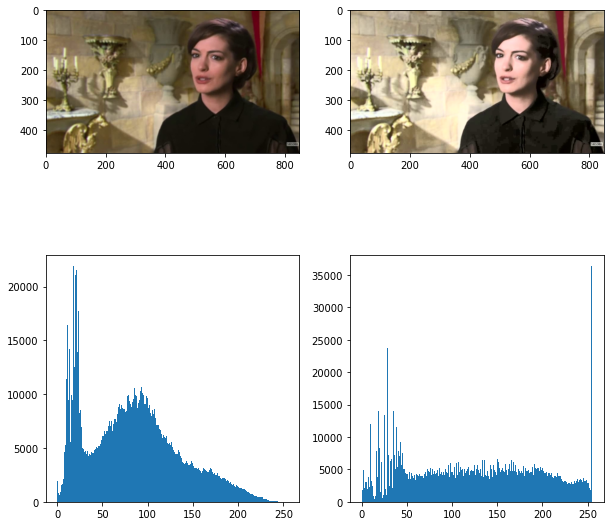

In [10]:
image = read_random_image()
mod_image = histogram_equalization(image)
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(10, 10)
axes[0, 0].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
axes[0, 1].imshow(cv.cvtColor(mod_image, cv.COLOR_BGR2RGB))
axes[1, 0].hist(image.ravel(), 256, (0, 255))
axes[1, 1].hist(mod_image.ravel(), 256, (0, 255))
plt.show()

## Adaptive histogram equalization

In [41]:
def adaptive_histogram_equalization(image: np.ndarray) -> np.ndarray:
    """Perform Adaptive Histogram Equalization on image.
    
    Equalization is done in YCbCr color space,
    after equalization image is converted back to BGR.
    
    Args:
        image: OpenCV image.
    
    Returns:
        Image after equalization.
    
    """
    # Convert from BGR color space to YCrCb
    ycrcb_image  = cv.cvtColor(image, cv.COLOR_BGR2YCrCb)
    # Prepare CLAHE
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    # Eqalize y channel
    ycrcb_image[:, :, 0] = clahe.apply(ycrcb_image[:, :, 0])
    # Convert back to BGR
    return cv.cvtColor(ycrcb_image, cv.COLOR_YCrCb2BGR)

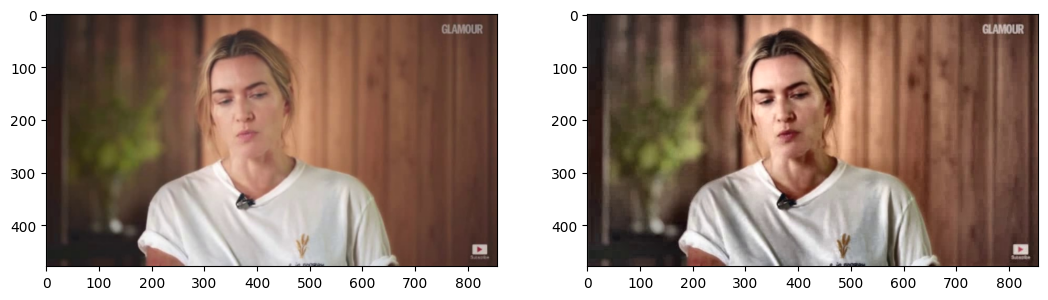

In [42]:
show_single_image_modification(image, adaptive_histogram_equalization)

## Brighness & contrast

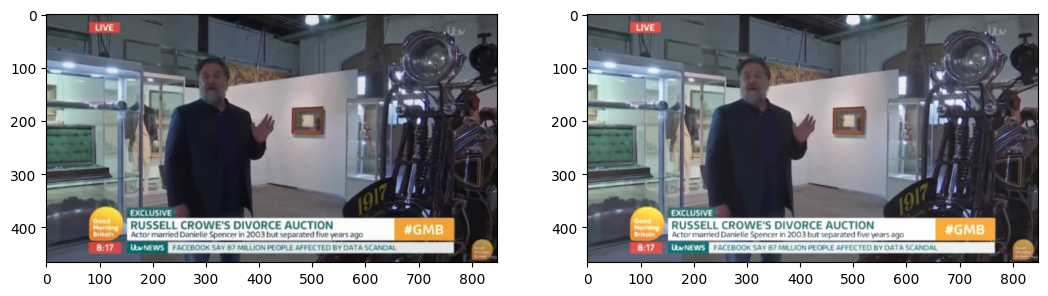

In [16]:
image = read_random_image()
show_single_image_modification(image, cv.convertScaleAbs, alpha=1.0, beta=10)

In [19]:
# Automatic brightness and contrast optimization with optional histogram clipping
def correct_brightness_and_contrast(image: np.ndarray, clip_hist_percent=1):
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # Calculate grayscale histogram
    hist = cv.calcHist([gray_image], [0], None, [256], [0, 256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum / 100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha

    # Calculate new histogram with desired range and show histogram
    """
    new_hist = cv.calcHist([gray_image],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    """
    return cv.convertScaleAbs(image, alpha=alpha, beta=beta)
    

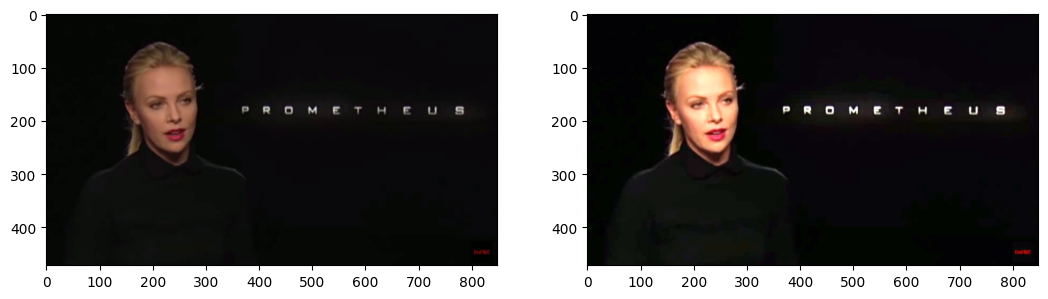

In [21]:
image = read_random_image()
show_single_image_modification(image, correct_brightness_and_contrast, clip_hist_percent=1)

## Red eye effect removal
Using dlib face detector
1. Find eyes
2. Find pupils via mask?

In [6]:
import dlib

In [7]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    # return the list of (x, y)-coordinates
    return coords

In [8]:
image = read_random_image()

In [9]:
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(
    "/media/cicheck/Extreme Pro/models/shape_predictor_68_face_landmarks.dat"
)

In [10]:
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
# detect faces in the grayscale image
rects = detector(gray, 1)

In [11]:
rect = rects[0]

In [12]:
shape = predictor(gray, rect)

In [13]:
LEFT_EYE_INDICES = list(range(36, 42))

In [14]:
RIGHT_EYE_INDICES = list(range(42, 48))

In [15]:
EYES_INDICES = LEFT_EYE_INDICES + RIGHT_EYE_INDICES

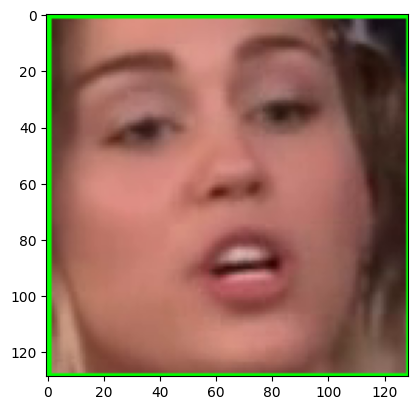

In [72]:
image = read_random_image()
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
# detect faces in the grayscale image
rects = detector(gray, 1)
rect = rects[0]
shape = predictor(gray, rect)
shape = predictor(gray, rect)
shape = shape_to_np(shape)
(x, y, w, h) = rect_to_bb(rect)
cv.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
eyes_landmarks = [landmark for index, landmark in enumerate(shape) if index in EYES_INDICES]
#for x, y in eyes_landmarks:
    #cv.circle(image, (x, y), 1, (0, 0, 255), -1)
# show the output image with the face detections + facial landmarks
x, y, w, h = rect_to_bb(rect)
show_single_image(image[y:y+h, x:x+w])

In [77]:
left_eye_landmarks

[array([379,  98]),
 array([385,  94]),
 array([392,  92]),
 array([399,  94]),
 array([393,  97]),
 array([386,  99])]

In [78]:
# No need to use dedicated function...
convex_hull = np.array(left_eye_landmarks)

In [79]:
convex_hull

array([[379,  98],
       [385,  94],
       [392,  92],
       [399,  94],
       [393,  97],
       [386,  99]])

In [80]:
# Create mask
mask = np.zeros(image.shape, np.uint8)
mask = cv.drawContours(mask, np.array([np.squeeze(convex_hull)]), -1, (255,255,255), cv.FILLED)
mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)

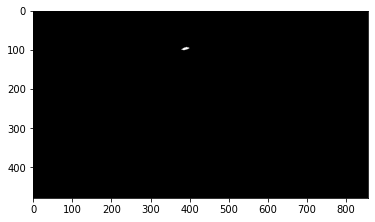

In [83]:
plt.imshow(mask[...], cmap="gray")

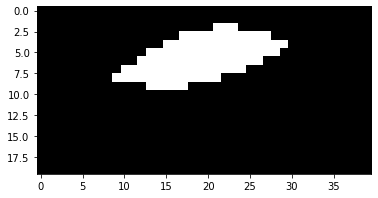

In [90]:
plt.imshow(mask[90:110,370:410], cmap="gray")

In [101]:
min_channel = np.amin(image, axis=2)

In [105]:
min_channel[is_eye_pixel].mean()

55.225806451612904

In [111]:
brightness_threshold = 35

In [112]:
is_eye_pixel = mask == 255

In [113]:
is_pupil = min_channel < brightness_threshold

In [114]:
is_eye_pixel

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [115]:
final.shape

(478, 856, 3)

In [118]:
final = image.copy()
# TODO: change operation to actual red eye
# final[eye_pixels & is_pupil, :] = final[eye_pixels & is_pupil, :] + (0, 128, 0)
# Apply some smart scaling
final[eye_pixels & is_pupil, :] = final[eye_pixels & is_pupil, :] + (0, 0, 128)

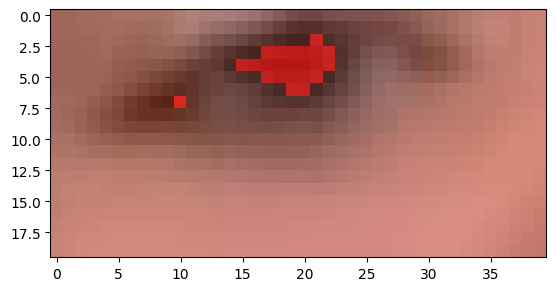

In [119]:
show_single_image(final[90:110,370:410])

In [76]:
left_eye_landmarks = eyes_landmarks[0:6]

In [23]:
x_cords, y_cords = zip(*left_eye_landmarks)

In [24]:
min_x, max_x = min(x_cords), max(x_cords)

In [25]:
min_y, max_y = min(y_cords), max(y_cords)

In [26]:
bounding_box = image[min_y:max_y, min_x:max_x]

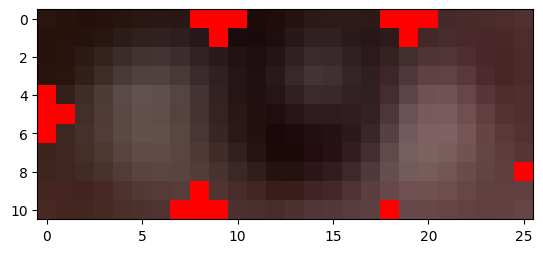

In [27]:
show_single_image(bounding_box)

In [45]:
bounding_box_gray = gray[min_y:max_y, min_x:max_x]

In [56]:
threshold = cv.adaptiveThreshold(
    bounding_box_gray, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 7, 3
)

In [54]:
_, threshold = cv.threshold(
    bounding_box_gray, 80, 255, cv.THRESH_BINARY
)

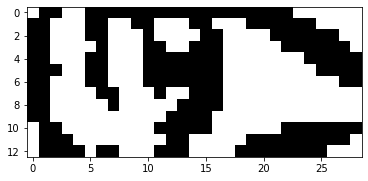

In [57]:
plt.imshow(threshold, cmap="gray")

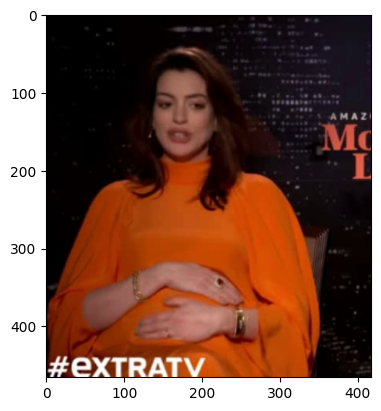

In [8]:
from pupil_detectors import Detector2D

image = read_random_image()

detector = Detector2D()

gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

result = detector.detect(gray)
ellipse = result["ellipse"]

cv.ellipse(
    image,
    tuple(int(v) for v in ellipse["center"]),
    tuple(int(v / 2) for v in ellipse["axes"]),
    ellipse["angle"],
    0, 360,
    (0, 0, 255) # color (BGR): red
)
show_single_image(image)